# K-Nearest Neighbors Classifier

In [9]:
import pickle

data = pickle.load( open( "../data/data_encodings_neu.p", "rb" ) )

Train test split

In [10]:
from sklearn.model_selection import train_test_split

features = data.columns[data.columns != "readmitted"].tolist()
target_value = ["readmitted"]

X = data[features]
y = data[target_value]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

Imbalance of the readmission variable

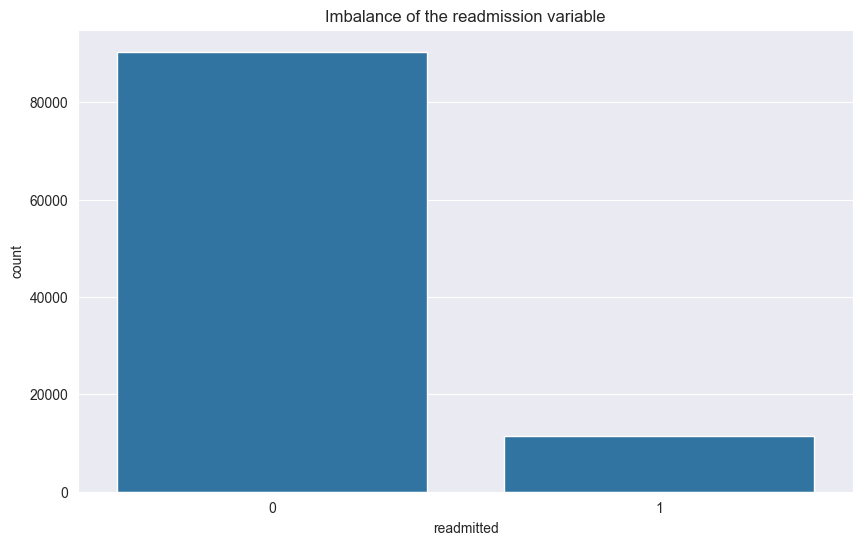

In [11]:
from matplotlib import pyplot as plt
import seaborn as sns

plt.figure(figsize=(10,6))
sns.countplot(x='readmitted', data=data)
plt.title('Imbalance of the readmission variable')
plt.show()

## Normal KNN

In [12]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix

knn = KNeighborsClassifier(n_neighbors=3)

knn.fit(X_train, y_train.values.ravel())
y_pred = knn.predict(X_test)

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))
print("Classification Report:")
print(classification_report(y_test, y_pred))

Confusion Matrix:
[[17199   868]
 [ 2027   260]]
Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.95      0.92     18067
           1       0.23      0.11      0.15      2287

    accuracy                           0.86     20354
   macro avg       0.56      0.53      0.54     20354
weighted avg       0.82      0.86      0.84     20354


## Oversampling with SMOTE

In [13]:
from imblearn.over_sampling import SMOTE

smote = SMOTE()
X_train_oversampled, y_train_oversampled = smote.fit_resample(X_train, y_train)

print("Before SMOTE:")
print(y_train['readmitted'].value_counts())
print("\nAfter SMOTE:")
print(y_train_oversampled['readmitted'].value_counts())

Before SMOTE:
readmitted
0    72342
1     9070
Name: count, dtype: int64

After SMOTE:
readmitted
0    72342
1    72342
Name: count, dtype: int64


### k-NN with oversampling

In [14]:
knn = KNeighborsClassifier(n_neighbors=3)

knn.fit(X_train_oversampled, y_train_oversampled.values.ravel())
y_pred = knn.predict(X_test)

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))
print("Classification Report:")
print(classification_report(y_test, y_pred))

Confusion Matrix:
[[12315  5752]
 [ 1538   749]]
Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.68      0.77     18067
           1       0.12      0.33      0.17      2287

    accuracy                           0.64     20354
   macro avg       0.50      0.50      0.47     20354
weighted avg       0.80      0.64      0.70     20354


## Undersampling with RandomUnderSampler

In [15]:
from imblearn.under_sampling import RandomUnderSampler

rus = RandomUnderSampler()

X_train_undersampled, y_train_undersampled = rus.fit_resample(X_train, y_train)

print("Before undersampling:")
print(y_train['readmitted'].value_counts())
print("\nAfter undersampling:")
print(y_train_undersampled['readmitted'].value_counts())

Before undersampling:
readmitted
0    72342
1     9070
Name: count, dtype: int64

After undersampling:
readmitted
0    9070
1    9070
Name: count, dtype: int64


### k-NN with undersampling

In [16]:
knn = KNeighborsClassifier(n_neighbors=3)

# Fit the model using the undersampled training data
knn.fit(X_train_undersampled, y_train_undersampled.values.ravel())

# Predict the labels of the test set
y_pred = knn.predict(X_test)

# Print the confusion matrix
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

# Print the classification report
print("Classification Report:")
print(classification_report(y_test, y_pred))

Confusion Matrix:
[[9373 8694]
 [1020 1267]]
Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.52      0.66     18067
           1       0.13      0.55      0.21      2287

    accuracy                           0.52     20354
   macro avg       0.51      0.54      0.43     20354
weighted avg       0.81      0.52      0.61     20354
